In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt

import datetime
import yfinance as yf # for demonstration of data only

In [2]:
# List of stock tickers
tickers = ['WMT', 'AMZN', 'MSFT', 'NEE', 'EQIX', 'TSLA']

# Download stock data from Yahoo Finance starting from 2018 until now
start_date = "2018-01-01"
end_date = pd.Timestamp.now().strftime("%Y-%m-%d")  # Get today's date

# Fetch the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Display the first few rows
data.head()

[*********************100%%**********************]  6 of 6 completed


Ticker,AMZN,EQIX,MSFT,NEE,TSLA,WMT
Date,,,,,,
2018-01-02,59.450500,393.783478,79.792915,32.989731,21.368668,29.255863
2018-01-03,60.209999,395.598511,80.164261,32.289902,21.150000,29.511066
2018-01-04,60.479500,394.691010,80.869812,32.123981,20.974667,29.537775
2018-01-05,61.457001,396.047882,81.872452,32.270756,21.105333,29.712843
2018-01-08,62.343498,403.722290,81.956001,32.536652,22.427334,30.152025


In [3]:
# Get daily log return
r = np.log(data / data.shift(1)).dropna()
r.head()

Ticker,AMZN,EQIX,MSFT,NEE,TSLA,WMT
Date,,,,,,
2018-01-03,0.012694,0.004599,0.004643,-0.021442,-0.010286,0.008685
2018-01-04,0.004466,-0.002297,0.008763,-0.005152,-0.008325,0.000905
2018-01-05,0.016033,0.003432,0.012322,0.004559,0.006210,0.005909
2018-01-08,0.014322,0.019192,0.001020,0.008206,0.060755,0.014673
2018-01-09,0.004665,-0.004857,-0.000680,-0.007349,-0.008118,-0.012080


## NORMALITY

In [5]:
def skewness_his(r):
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()  # Numerator
    return exp / sigma_r**3  # Skewness formula

# Manual Kurtosis calculation
def kurtosis_his(r):
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp / sigma_r**4  # Kurtosis formula

# Jarque-Bera Test for Normality
def is_normal(r, level=0.01):
    jb_stat, jb_p_value = stats.jarque_bera(r)
    return jb_p_value > level, jb_stat, jb_p_value  # Return JB result and p-value for interpretation


# Combine function to check normality for a single asset return series
def check_normality(r, level=0.01):
    """
    This function calculates skewness, kurtosis, and the JB test for normality for a single asset's return series.
    
    Parameters:
    - r: A pandas Series with the asset's return data.
    - level: The significance level for the JB test (default is 1%).
    
    Returns:
    - A DataFrame with skewness, kurtosis, JB statistics, JB p-value, and normality check for the asset.
    """
    # Calculate skewness, kurtosis, and JB test
    skewness = skewness_his(r)
    kurtosis = kurtosis_his(r)
    jb_result, jb_stat, jb_p_value = is_normal(r, level)
    
    # Return the result as a DataFrame
    return pd.DataFrame({
        'Skewness': [skewness],
        'Kurtosis': [kurtosis],
        'JB Statistic': [jb_stat],
        'JB p-value': [jb_p_value],
        'Is Normal (JB Test)': [jb_result]
    })

In [6]:
check_normality(r.AMZN)

,Skewness,Kurtosis,JB Statistic,JB p-value,Is Normal (JB Test)
0,-0.161588,7.068937,1183.603362,9.633754e-258,False


In [7]:
# Function to check normality for multiple asset return series
def check_normality_multiple(returns_df, level=0.01):
    """
    This function calculates skewness, kurtosis, and the JB test for normality for multiple assets.
    
    Parameters:
    - returns_df: A DataFrame where each column is a different asset's return series.
    - level: The significance level for the JB test (default is 1%).
    
    Returns:
    - A DataFrame with skewness, kurtosis, JB statistics, JB p-value, and normality check for each asset.
    """
    # Define a function to apply to each column
    def apply_normality_checks(r):
        skewness = skewness_his(r)
        kurtosis = kurtosis_his(r)
        jb_result, jb_stat, jb_p_value = is_normal(r, level)
        
        return pd.Series({
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'JB Statistic': jb_stat,
            'JB p-value': jb_p_value,
            'Is Normal (JB Test)': jb_result
        })
    
    # Apply the function to each column (asset) in the DataFrame
    return returns_df.apply(apply_normality_checks)

In [8]:
check_normality_multiple(r)

Ticker,AMZN,EQIX,MSFT,NEE,TSLA,WMT
Skewness,-0.161588,0.047983,-0.242783,-0.491359,-0.140149,-0.336368
Kurtosis,7.068937,8.418911,10.099203,12.683341,6.520389,18.108233
JB Statistic,1183.603362,2086.764106,3597.156362,6729.978229,886.010555,16248.030476
JB p-value,0.0,0.0,0.0,0.0,0.0,0.0
Is Normal (JB Test),False,False,False,False,False,False


## VaR CALCULATIONS

In [10]:
# Function to calculate Historical VaR
def var_his(r, level):  
    """Calculate historical VaR at a given level (percentile)."""
    return -np.percentile(r, level)  # VaR is positive

# Function to calculate Parametric VaR (Gaussian)
def var_gaussian(r, level):
    """Calculate parametric (Gaussian) VaR at a given confidence level."""
    mean_r = r.mean()  # Calculate once
    std_r = r.std()  # Set dd0f = 0 if we need population standard deviation
    z = norm.ppf(level)  # Z-score for the given confidence level
    return -(mean_r + z * std_r)  # Parametric VaR formula

# Function to calculate Cornish-Fisher VaR (Modified)
def var_cofi(r, level):
    """Calculate Cornish-Fisher VaR at a given confidence level."""
    mean_r = r.mean()  # Calculate once
    std_r = r.std()  #Set dd0f = 0 if we need population standard deviation
    z = norm.ppf(level)
    s = skewness_his(r)  # Custom skewness function (provided earlier)
    k = kurtosis_his(r)  # Custom kurtosis function (provided earlier)
    # Adjust z-score using Cornish-Fisher expansion
    z_cf = z + (z**2 - 1) * s / 6 + (z**3 - 3 * z) * (k - 3) / 24 - (2 * z**3 - 5 * z) * (s**2) / 36
    return -(mean_r + z_cf * std_r)  # Cornish-Fisher VaR formula

# Function to display VaR comparison across approaches for 1 asset
def var_comparison(r, level):
    """Compare VaR across three methods (historical, Gaussian, Cornish-Fisher)."""
    var_list = [
        var_his(r, level * 100), 
        var_gaussian(r, level), 
        var_cofi(r, level)
    ]
    # Create a DataFrame to hold the results
    var_tbl = pd.DataFrame(var_list, index=['Historical VaR', 'Parametric Gaussian VaR', 'Cornish-Fisher VaR'], 
                           columns=[f'VaR at {level * 100}%'])
    print(var_tbl)
    
    # Plot the results
    var_tbl.plot.bar(color=['skyblue', 'lightgreen', 'salmon'], legend=False)
    plt.title(f'VaR Comparison at {level * 100}%')
    plt.ylabel('VaR')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.show()

# Function to display VaR comparison for multiple assets
def var_comparison_multiple_assets(returns_df, level):
    """Compare VaR for multiple assets using three methods."""
    results = []  # Store results in a list (more efficient than repeatedly concatenating DataFrames)
    
    # Loop over each asset
    for asset in returns_df.columns:
        r = returns_df[asset].dropna()  # Drop missing values
        
        # Calculate VaR using the three approaches
        var_historical = var_his(r, level * 100)
        var_gauss = var_gaussian(r, level)
        var_cornish = var_cofi(r, level)
        
        # Collect the results for this asset
        results.append({
            'Asset': asset,
            'Historical VaR': var_historical,
            'Parametric Gaussian VaR': var_gauss,
            'Cornish-Fisher VaR': var_cornish
        })
        
        # Plot the results for each asset
        pd.DataFrame([results[-1]]).set_index('Asset').T.plot.bar(color=['skyblue', 'lightgreen', 'salmon'], legend=False)
        plt.title(f'VaR Comparison for {asset} at {level * 100}% Confidence Level')
        plt.ylabel('VaR')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    
    # Convert the results list into a DataFrame
    return pd.DataFrame(results)

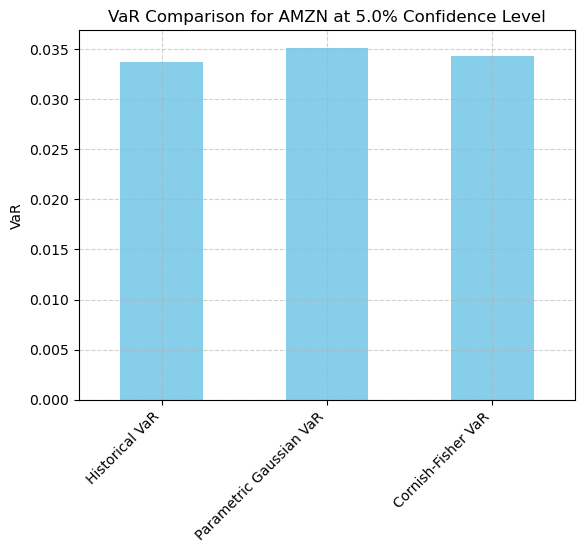

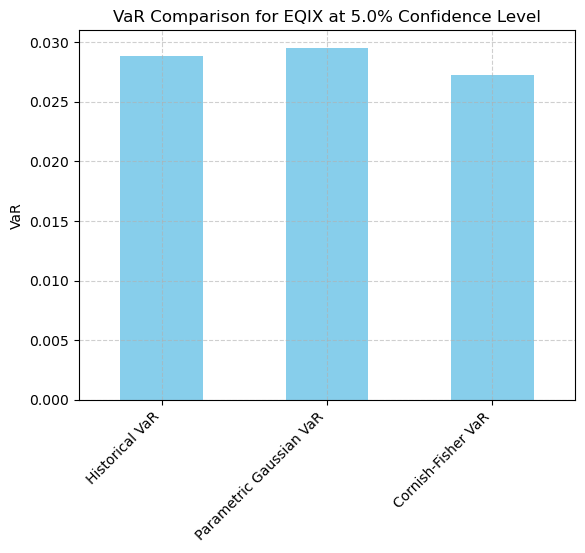

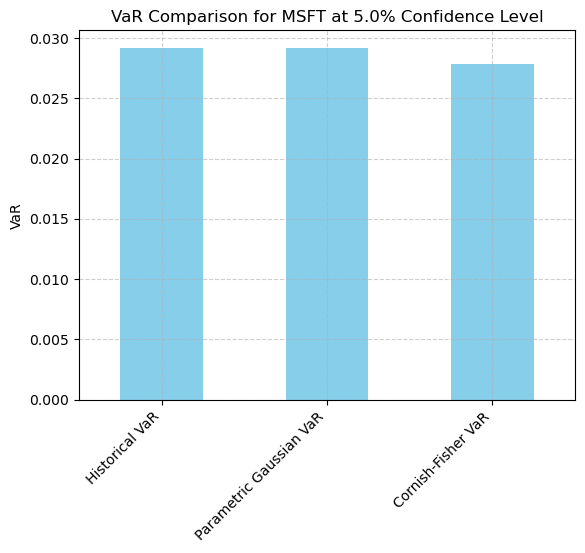

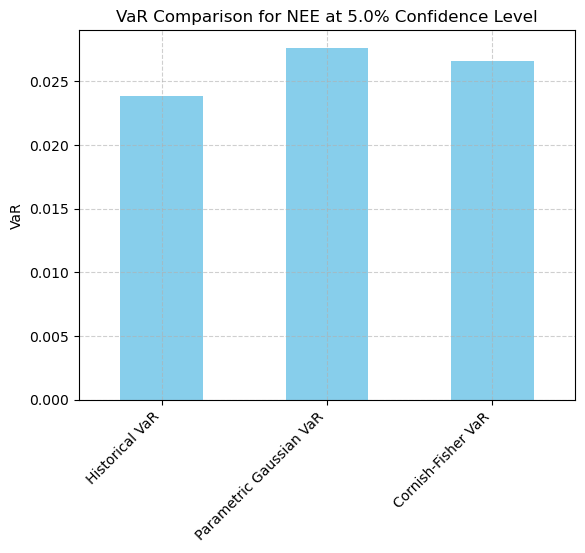

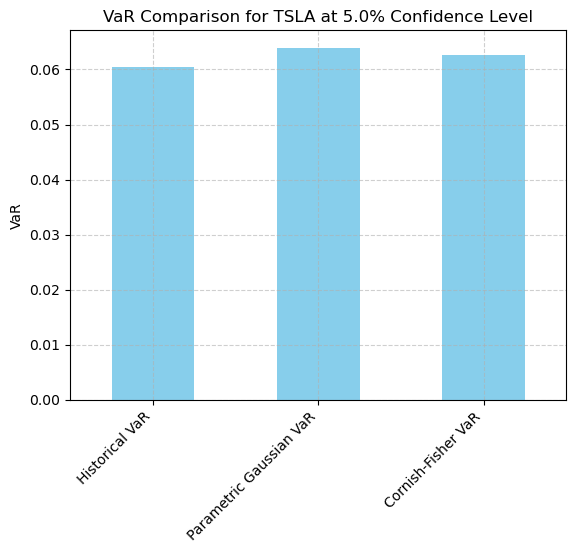

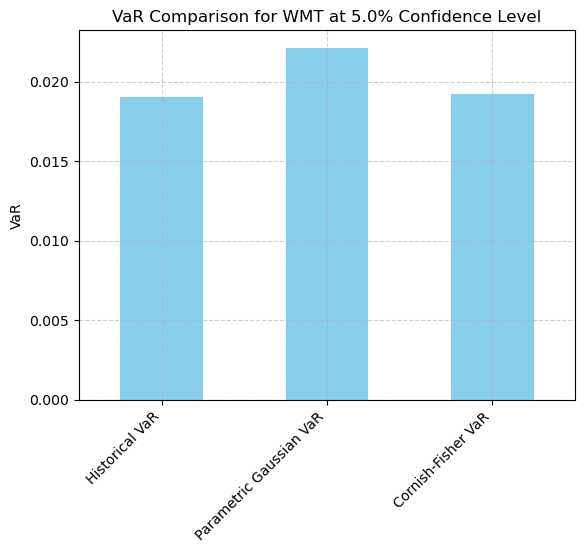

,Asset,Historical VaR,Parametric Gaussian VaR,Cornish-Fisher VaR
0,AMZN,0.033664,0.035127,0.034329
1,EQIX,0.028866,0.029511,0.027269
2,MSFT,0.029169,0.029180,0.027799
3,NEE,0.023863,0.027626,0.026594
4,TSLA,0.060509,0.063937,0.062684
5,WMT,0.019063,0.022141,0.019219


In [11]:
var_comparison_multiple_assets(r, 0.05)

In [12]:
# Function to calculate Conditional VaR (CVaR)
def cvar_his(r, level):
    """Calculate Conditional VaR (CVaR) using historical data."""
    var_value = var_his(r, level * 100)  # Calculate historical VaR first
    is_beyond = r <= -var_value  # Check which returns are beyond the VaR threshold
    return -r[is_beyond].mean()  # Return the mean of the worst returns

# Function to calculate CVaR for multiple assets
def cvar_his_multiple_assets(returns_df, level):
    """Calculate CVaR for multiple assets."""
    results = []  # Store results in a list
    
    # Loop over each asset
    for asset in returns_df.columns:
        r = returns_df[asset].dropna()  # Drop missing values
        
        # Calculate CVaR for the asset
        cvar_value = cvar_his(r, level)
        
        # Collect the results for this asset
        results.append({
            'Asset': asset,
            'CVaR': cvar_value
        })
    
    # Convert the results list into a DataFrame
    return pd.DataFrame(results)

In [13]:
cvar_his_multiple_assets(r, 0.05)

,Asset,CVaR
0,AMZN,0.050973
1,EQIX,0.040776
2,MSFT,0.041731
3,NEE,0.041367
4,TSLA,0.092292
5,WMT,0.030876
